# Visualize predicted dates

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys, scipy

In [3]:
gpt35 = pd.read_csv('GPT35_publicationyears.tsv', sep='\t')

In [4]:
gpt35.head()

,text,label,prediction
0,"On the contrary, he argues that the Teutonic t...",1,1996.4344
1,For a quarter of a century this firm has stood...,1,1933.0599
2,It is important to remember that the purpose o...,1,1997.6356
3,"Hence, by utilizing Euler's formulae, we can f...",1,2001.2347
4,"""You jest make it good an' heavy an' pufFon th...",0,1911.4178


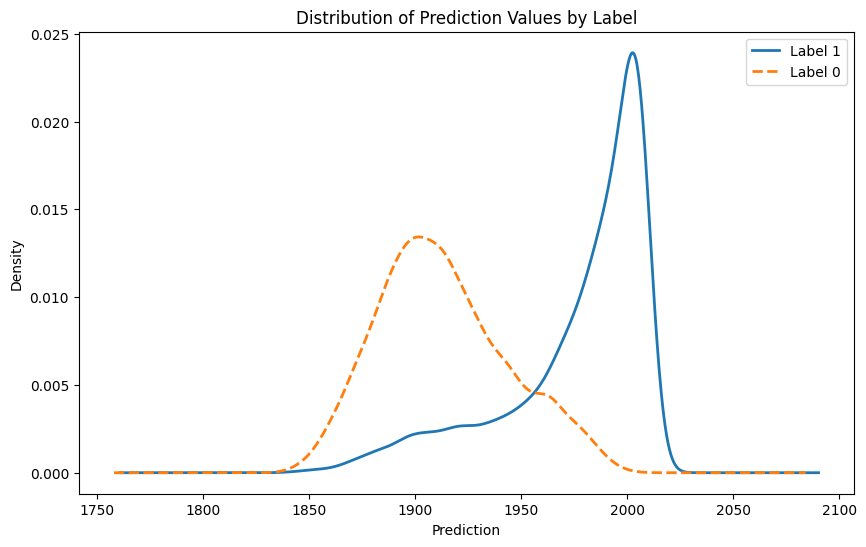

In [8]:
# Separate the dataframe into two subsets
gpt35_label_1 = gpt35[gpt35['label'] == 1]
gpt35_label_0 = gpt35[gpt35['label'] == 0]

# Plot the distribution of 'prediction' values using KDE
plt.figure(figsize=(10, 6))
gpt35_label_1['prediction'].plot(kind='kde', label='Label 1', linestyle='-', linewidth=2)
gpt35_label_0['prediction'].plot(kind='kde', label='Label 0', linestyle='--', linewidth=2)

# Add title and labels
plt.title('Distribution of Prediction Values by Label')
plt.xlabel('Prediction')
plt.ylabel('Density')
plt.legend()
plt.show()

In [10]:
gpt35 = gpt35_label_1
groundtruth = gpt35_label_0

In [12]:
gpt4o = pd.read_csv('GPT4o_publicationyears.tsv', sep='\t')

In [13]:
gpt1914 = pd.read_csv('GPT1914_publicationyears.tsv', sep='\t')

In [14]:
gpt1914 = gpt1914[gpt1914['label'] == 1]

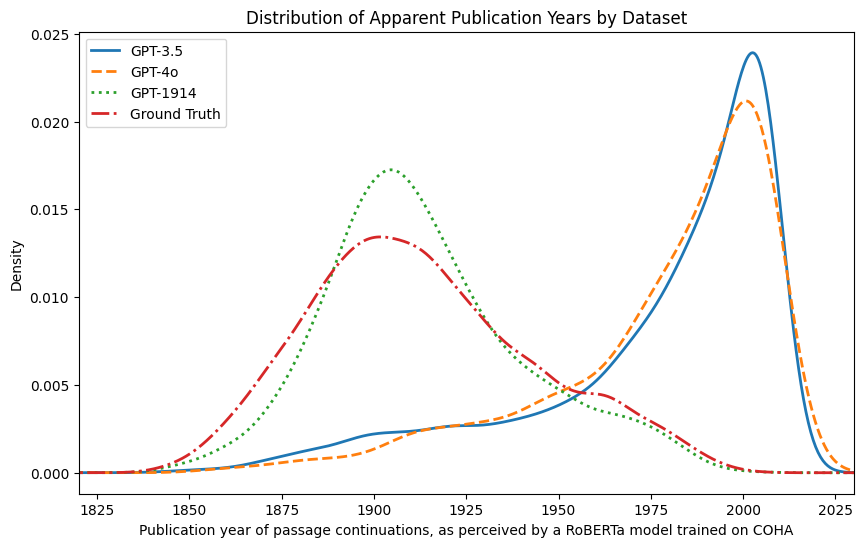

In [19]:
# We plot kernel density estimates of the publication years of all four datasets:
# the GPT-3.5 dataset, the GPT-4o dataset, the GPT-1914 dataset, and the ground truth dataset.
# Since real publication years don't extend below 1850 or above 2020, we limit the x-axis to this range.

plt.figure(figsize=(10, 6))
gpt35['prediction'].plot(kind='kde', label='GPT-3.5', linestyle='-', linewidth=2)
gpt4o['prediction'].plot(kind='kde', label='GPT-4o', linestyle='--', linewidth=2)
gpt1914['prediction'].plot(kind='kde', label='GPT-1914', linestyle=':', linewidth=2)
groundtruth['prediction'].plot(kind='kde', label='Ground Truth', linestyle='-.', linewidth=2)

plt.xlim(1820, 2030)
plt.title('Distribution of Apparent Publication Years by Dataset')
plt.xlabel('Publication year of passage continuations, as perceived by a RoBERTa model trained on COHA')
plt.ylabel('Density')
plt.legend()
plt.show()
